In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os 


from tensorflow.keras import layers
from tensorflow.keras.models import Model

import h5py
import datetime
import pickle
np.random.seed(2022)

In [ ]:
img = []
time = []
for i in range(1,8):
  f = h5py.File(f'/content/drive/MyDrive/Colab Notebooks/processed/1997-01-0{i}T00-00-00.h5', 'r')
  img.append(f["image"][...])
  time.append(f["time"][...])

In [ ]:
for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/hour"):
  f = h5py.File(f"/content/drive/MyDrive/Colab Notebooks/hour/{i}", 'r')
  img.append(f["image"][...])
  time.append(f["time"][...])
img_train = np.concatenate(img)
time_train = np.concatenate(time)

In [ ]:
old_time = datetime.datetime.strptime(time_train[0].decode()[:19],"%Y-%m-%dT%H:%M:%S")
sequence_images = []
current_sequence = []
time_deltas = []
for i in range(1,len(time_train)):
  new_time = datetime.datetime.strptime(time_train[i].decode()[:19],"%Y-%m-%dT%H:%M:%S")
  time_deltas.append((new_time - old_time).total_seconds())
  if (new_time - old_time) > datetime.timedelta(minutes=4) or len(current_sequence) == 10:
    sequence_images.append(current_sequence)
    current_sequence = []
  current_sequence.append(img_train[i])
  old_time = new_time
sequence_images.append(current_sequence)

del img_train, time_train, time_deltas,current_sequence,time
#plt.hist(np.array(time_deltas)/60,range=(0,4),bins=60 );

In [ ]:
sequence_images = np.array([ i for i in sequence_images if len(i)==10])/255
print(len(sequence_images))
x = np.array([i[:-1] for i in sequence_images])
y = np.array([i[1:] for i in sequence_images])
del sequence_images
stop_train = int(0.9*len(x))
train_x = x[:stop_train]
test_x = x[stop_train:]
del x
train_y = y[:stop_train]
test_y = y[stop_train:]
del y

3332


In [ ]:
x, y = [], []
for i in sequence_images:
  x += i[:-1]
  y += i[1:]
x, y = np.array(x), np.array(y)
del sequence_images

In [ ]:
x = x.astype("float32")/np.max(x)
y = y.astype("float32")/np.max(y)

stop_train = int(0.9*len(x))
train_x = x[:stop_train]
train_y = y[:stop_train]
test_x = x[stop_train:]
test_y = y[stop_train:]
del x, y

In [ ]:
def mse(pred,corr):
  mse = tf.keras.losses.MeanSquaredError()
  return float(mse(corr,pred).numpy())


In [ ]:
def recall(pred,corr):
  m = tf.keras.metrics.Recall(thresholds=0.11)
  m.update_state(corr>0.11,pred)
  return m.result().numpy()

In [ ]:
def precision(pred,corr):
  m = tf.keras.metrics.Precision(thresholds=0.11)
  m.update_state(corr>0.11,pred)
  return m.result().numpy()

In [ ]:
def f1(pred,corr):
    prec = precision(pred,corr)
    rec = recall(pred,corr)
    return 2*((prec*rec)/(prec+rec))

In [ ]:
def test_model(pred,corr):
  print("MSE:",mse(pred,corr))
  print("Recall:",recall(pred,corr))
  print("Precision:",precision(pred,corr))
  print("F1:",f1(pred,corr))

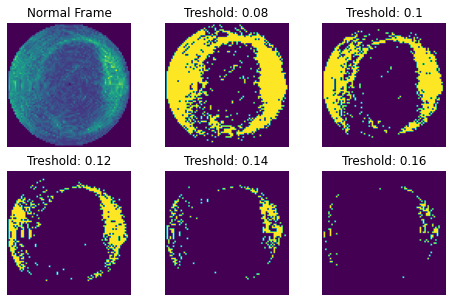

In [ ]:
j = 1900
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
# OG

axes[0][0].imshow(test_x[j])
axes[0][0].set_title(f"Normal Frame")
axes[0][0].axis("off")

for idx, ax in enumerate(axes[0][1:]):
    tresh = 0.08+idx*0.02
    ax.imshow(test_x[j]>tresh)
    ax.set_title(f"Treshold: {tresh}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    tresh = 0.12+idx*0.02
    ax.imshow(test_x[j]>tresh)
    ax.set_title(f"Treshold: {np.round(tresh,3)}")
    ax.axis("off")
plt.savefig("tresh_comparison.pdf")
plt.show()

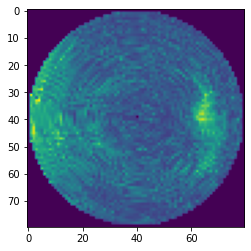

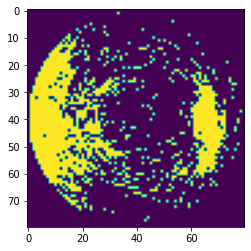

In [ ]:
#a = np.random.randint(0,len(test_x)-1)
plt.imshow(train_x[a])
plt.show()
plt.imshow(train_x[a]>0.08)
plt.show()

In [ ]:
def create_autoencoder():
  input = layers.Input(shape=(80, 80, 1))

  # Encoder
  x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)
  x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)

  # Decoder
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

  # Autoencoder
  autoencoder = Model(input, x)
  autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
  #autoencoder.summary()
  return autoencoder
autoencoder = create_autoencoder()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 80, 80, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 40, 40, 32)       9248  

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=7)

auto_hist = autoencoder.fit(
    x=train_x,
    y=train_y,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_x, test_y),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/50
248/248 [==============================] - 28s 57ms/step - loss: 0.2501 - val_loss: 0.2284 - lr: 0.0010
Epoch 2/50
248/248 [==============================] - 12s 50ms/step - loss: 0.2050 - val_loss: 0.2243 - lr: 0.0010
Epoch 3/50
248/248 [==============================] - 13s 51ms/step - loss: 0.2033 - val_loss: 0.2235 - lr: 0.0010
Epoch 4/50
248/248 [==============================] - 13s 51ms/step - loss: 0.2028 - val_loss: 0.2232 - lr: 0.0010
Epoch 5/50
248/248 [==============================] - 13s 51ms/step - loss: 0.2026 - val_loss: 0.2232 - lr: 0.0010
Epoch 6/50
248/248 [==============================] - 13s 51ms/step - loss: 0.2025 - val_loss: 0.2228 - lr: 0.0010
Epoch 7/50
248/248 [==============================] - 13s 52ms/step - loss: 0.2024 - val_loss: 0.2227 - lr: 0.0010
Epoch 8/50
248/248 [==============================] - 13s 52ms/step - loss: 0.2024 - val_loss: 0.2229 - lr: 0.0010
Epoch 9/50
248/248 [==============================] - 13s 53ms/step - loss: 0.20

In [ ]:
autoencoder.save('/content/drive/MyDrive/Colab Notebooks/autoencoder')
with open('/content/drive/MyDrive/Colab Notebooks/autoencoder/history', 'wb') as file_pi:
      pickle.dump(auto_hist.history, file_pi)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/autoencoder/assets


In [ ]:
autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/autoencoder')

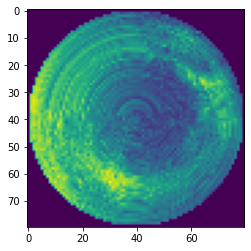

NameError: ignored

In [ ]:
a = np.random.randint(0,len(test_x)-1)
plt.imshow(test_x[a])
plt.show()
predictions = autoencoder.predict(test_x[a:a+1])
plt.imshow(predictions[0,...,0])
plt.show()
plt.imshow(test_y[a])
plt.show()

In [ ]:
test_model(np.squeeze(autoencoder.predict(test_x), axis=-1),test_y)

MSE: 0.0009034326
Recall: 0.79643244
Precision: 0.8127867
F1: 0.8045265078544617


In [ ]:
test_model(test_x,test_y)

MSE: 0.001794785
Recall: 0.75291806
Precision: 0.7483143
F1: 0.7506090998649597


In [ ]:
def create_unet(input=(80, 80, 1)):
  inputs = layers.Input(shape=input)


  # Encoder

  x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x 


  for filters in [64,128]:
      for _ in range(2):
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Residual
      residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual]) 
      previous_block_activation = x 

  # Decoder

  for filters in [128,64,32]:
      for _ in range(2):
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

      x = layers.UpSampling2D(2)(x)

      # Residual
      residual = layers.UpSampling2D(2)(previous_block_activation)
      residual = layers.Conv2D(filters, 1, padding="same")(residual)
      x = layers.add([x, residual])  
      previous_block_activation = x 

  outputs = layers.Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

  unet = Model(inputs, outputs)


  unet.compile(optimizer="adam", loss = 'binary_crossentropy')
  #unet.summary()
  return unet
unet = create_unet()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 40, 40, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 40, 40, 32)  128         ['conv2d_7[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 40, 40, 32)   0           ['batch_normalization_11[0]

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=7)

unet_hist = unet.fit(
    x=train_x,
    y=train_y,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_x, test_y),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/50
24/24 [==============================] - 6s 241ms/step - loss: 0.2042 - val_loss: 0.2318 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - 5s 188ms/step - loss: 0.2041 - val_loss: 0.2282 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - 5s 188ms/step - loss: 0.2039 - val_loss: 0.2246 - lr: 0.0010
Epoch 4/50
24/24 [==============================] - 5s 190ms/step - loss: 0.2041 - val_loss: 0.2250 - lr: 0.0010
Epoch 5/50
24/24 [==============================] - 5s 192ms/step - loss: 0.2041 - val_loss: 0.2241 - lr: 0.0010
Epoch 6/50
24/24 [==============================] - 5s 193ms/step - loss: 0.2037 - val_loss: 0.2233 - lr: 0.0010
Epoch 7/50
24/24 [==============================] - 5s 195ms/step - loss: 0.2037 - val_loss: 0.2228 - lr: 0.0010
Epoch 8/50
24/24 [==============================] - 5s 194ms/step - loss: 0.2037 - val_loss: 0.2224 - lr: 0.0010
Epoch 9/50
24/24 [==============================] - 5s 193ms/step - loss: 0.2036 - val_loss: 0.2

In [ ]:
unet.save('/content/drive/MyDrive/Colab Notebooks/unet')
with open('/content/drive/MyDrive/Colab Notebooks/unet/history', 'wb') as file_pi:
      pickle.dump(unet_hist.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/unet/assets


In [ ]:
test_model(np.squeeze(unet.predict(test_x), axis=-1),test_y)

MSE: 0.0009037001
Recall: 0.7968821
Precision: 0.8113298
F1: 0.8040410876274109


In [ ]:
a = np.random.randint(0,len(test_x)-1)
plt.imshow(test_x[a,-1])
plt.show()
predictions = unet.predict(np.moveaxis(test_x[a:a+1],-3,-1))
plt.imshow(predictions[0,...,0])
plt.show()
plt.imshow(test_y[a,-1])
plt.show()

NameError: ignored

In [ ]:
test_model(np.squeeze(unet.predict(np.moveaxis(test_x,-3,-1)), axis=-1),test_y[:,-1,...])

MSE: 0.0007890216074883938
Recall: 0.7469093
Precision: 0.80053544
F1: 0.772793173789978


In [ ]:
def create_convlstm():

  inp = layers.Input(shape=(None,80, 80, 1))

  # 3 ConvLSTM layers with decreasing kernel sizes
  x = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(5, 5),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(inp)
  x = layers.BatchNormalization()(x) # Normalize
  x = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(3, 3),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(x)
  x = layers.BatchNormalization()(x)
  x = layers.ConvLSTM2D(
      filters=64,
      kernel_size=(1, 1),
      padding="same",
      return_sequences=True,
      activation="relu",
  )(x)
  x = layers.Conv3D(
      filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
  )(x)


  convlstm = Model(inp, x)
  convlstm.compile(optimizer="adam", loss = 'binary_crossentropy')
  return convlstm
convlstm = create_convlstm()


In [ ]:
# Define modifiable training hyperparameters.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 15
batch_size = 10

# Fit the model to the training data.
hist = convlstm.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_x, test_y),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15
300/300 [==============================] - 329s 1s/step - loss: 0.2066 - val_loss: 0.2577 - lr: 0.0010
Epoch 2/15
300/300 [==============================] - 315s 1s/step - loss: 0.2002 - val_loss: 0.2243 - lr: 0.0010
Epoch 3/15
300/300 [==============================] - 316s 1s/step - loss: 0.1998 - val_loss: 0.2202 - lr: 0.0010
Epoch 4/15
300/300 [==============================] - 315s 1s/step - loss: 0.1997 - val_loss: 0.2202 - lr: 0.0010
Epoch 5/15
300/300 [==============================] - 316s 1s/step - loss: 0.1995 - val_loss: 0.2197 - lr: 0.0010
Epoch 6/15
300/300 [==============================] - 316s 1s/step - loss: 0.1993 - val_loss: 0.2201 - lr: 0.0010
Epoch 7/15
300/300 [==============================] - 316s 1s/step - loss: 0.1989 - val_loss: 0.2190 - lr: 0.0010
Epoch 8/15
300/300 [==============================] - 316s 1s/step - loss: 0.1989 - val_loss: 0.2190 - lr: 0.0010
Epoch 9/15
300/300 [==============================] - 316s 1s/step - loss: 0.1988 - val_

In [ ]:
convlstm.save('/content/drive/MyDrive/Colab Notebooks/convlstm')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/convlstm/assets


In [ ]:
convlstm = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/convlstm')

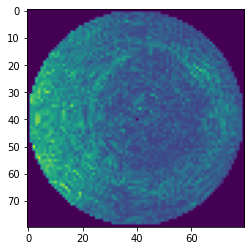

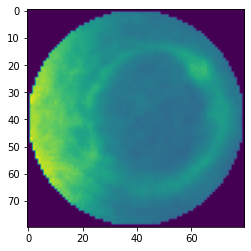

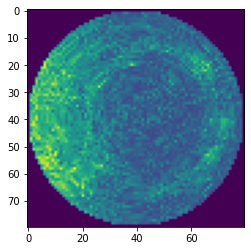

In [ ]:
j = 200
i = 8
plt.imshow(test_x[j:j+1,0:i+1][0][-1])
plt.show()
predictions = convlstm.predict(test_x[j:j+1,0:i+1])
plt.imshow(predictions[0,-1,...,0])
plt.show()
plt.imshow(test_y[j][i])
plt.show()


In [ ]:
test_model(np.squeeze(convlstm.predict(test_x)[:,-1], axis=-1),test_y[:,-1,...])

MSE: 0.0007068788399919868
Recall: 0.80154186
Precision: 0.80807596
F1: 0.8047956228256226


(1, 80, 80) (17, 80, 80)
(1, 80, 80) (18, 80, 80)


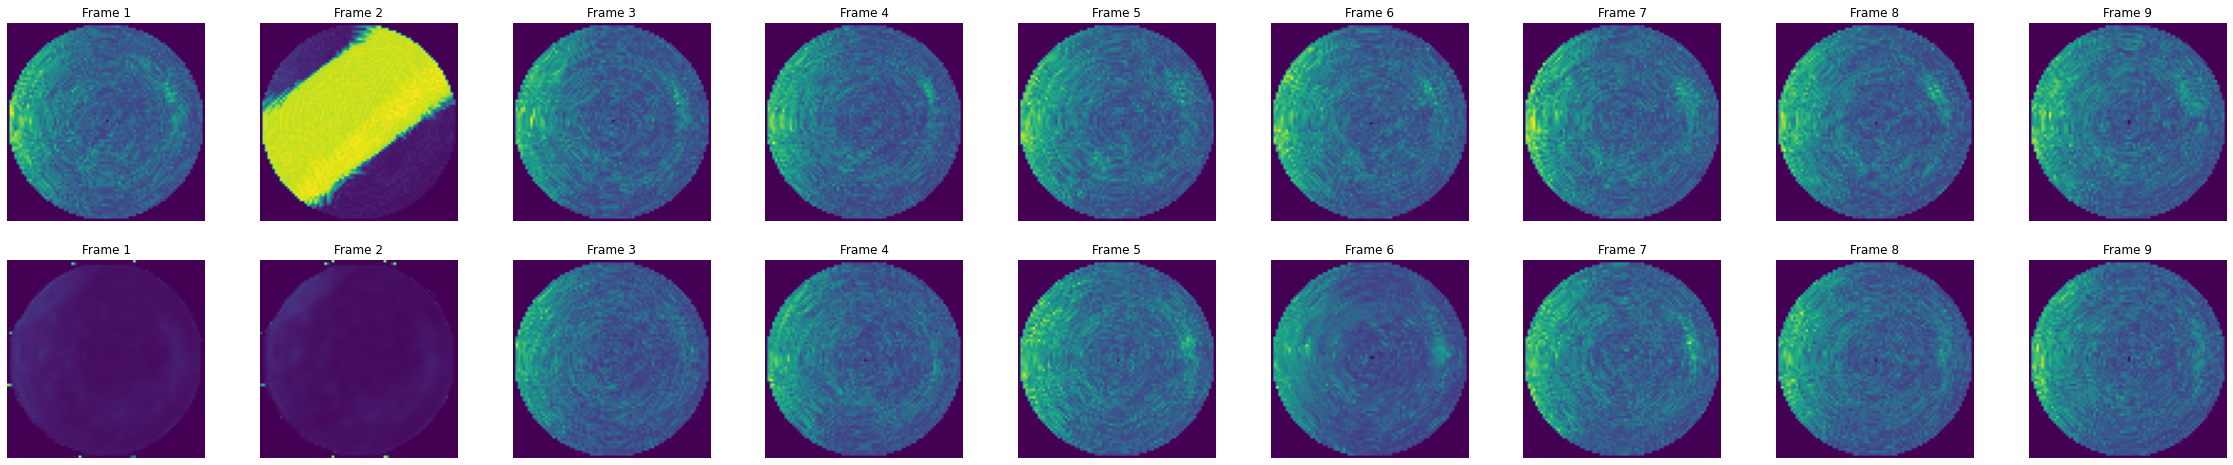

In [ ]:
i=8
frames = test_x[j,:i, ...]
original_frames = test_y[j,i-1:, ...]

for _ in range(len(original_frames)):
    new_prediction = convlstm.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=-1)
    predicted_frame = new_prediction[:,-1, ...]
    print(predicted_frame.shape,frames.shape)

    frames = np.concatenate((frames, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 9, figsize=(4*10, 8))


# OG
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(test_y[j,idx]))
    ax.set_title(f"Frame {idx+1}")
    ax.axis("off")

# Predicted
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(frames[idx+1]))
    ax.set_title(f"Frame {idx+1}")
    ax.axis("off")
plt.show()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)

unet_seq_hist = unet_seq.fit(
    x=np.moveaxis(train_x,-3,-1),
    y=train_y[:,-1,...],
    epochs=3,
    batch_size=64,
    shuffle=True,
    validation_data=(np.moveaxis(test_x,-3,-1), test_y[:,-1,...]),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/3
47/47 [==============================] - 168s 4s/step - loss: 0.2034 - val_loss: 0.2222 - lr: 0.0010
Epoch 2/3
47/47 [==============================] - 171s 4s/step - loss: 0.2033 - val_loss: 0.2231 - lr: 0.0010
Epoch 3/3
47/47 [==============================] - 175s 4s/step - loss: 0.2034 - val_loss: 0.2216 - lr: 0.0010


In [ ]:
unet_seq.save('/content/drive/MyDrive/Colab Notebooks/unet_seq')
with open('/content/drive/MyDrive/Colab Notebooks/unet_seq/history', 'wb') as file_pi:
      pickle.dump(unet_seq_hist.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/unet_seq/assets


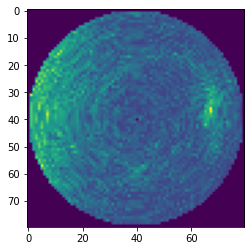

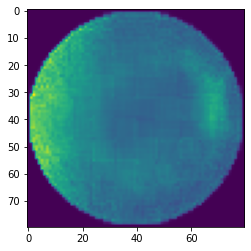

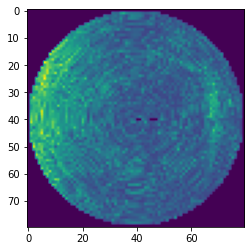

In [ ]:
a = np.random.randint(0,len(test_x)-1)
plt.imshow(test_x[a,-1])
plt.show()
predictions = unet.predict(np.moveaxis(test_x[a:a+1],-3,-1))
plt.imshow(predictions[0,...,0])
plt.show()
plt.imshow(test_y[a,-1])
plt.show()

In [ ]:
np.concatenate([np.lib.stride_tricks.sliding_window_view(i,10,axis=0) for i in np.arange(400).reshape(10,-1) if len(i) > 10])

array([[  0,   1,   2, ...,   7,   8,   9],
       [  1,   2,   3, ...,   8,   9,  10],
       [  2,   3,   4, ...,   9,  10,  11],
       ...,
       [388, 389, 390, ..., 395, 396, 397],
       [389, 390, 391, ..., 396, 397, 398],
       [390, 391, 392, ..., 397, 398, 399]])

In [ ]:
sequence_images = [np.array(i)/255 for i in sequence_images]

In [ ]:
def train():
  X = [np.lib.stride_tricks.sliding_window_view(i,10,axis=0)[:-1] for i in sequence_images if len(i) > 10]
  Y = [i for i in sequence_images if len(i) > 10]
  x,y = [],[]
  while True:
    for i in range(len(X)):
      for j in range(len(X[i])):
        x.append(np.moveaxis(X[i][j],0,1))
        y.append(Y[i][j+1])
        if len(x) > 4:
          yield np.array(x),np.array(y)
          x,y = [],[]

In [ ]:
unet_seq = create_unet((80, 80, 9))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4)

unet_hist = unet_seq.fit(
    x=np.moveaxis(train_x,-3,-1),
    y=train_y[:,-1,...],
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(np.moveaxis(test_x,-3,-1), test_y[:,-1,...]),
    callbacks=[early_stopping, reduce_lr],
)

In [ ]:
autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/autoencoder')
unet = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/unet')
#unet_seq = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/unet_seq')
convlstm = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/convlstm')

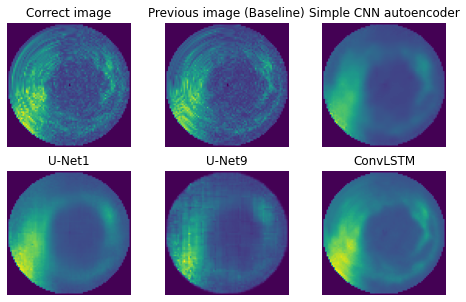

In [ ]:
j = 240
fig, axes = plt.subplots(2, 3, figsize=(8, 5))

axes[0][0].imshow(test_y[j][-1])
axes[0][0].set_title(f"Correct image")
axes[0][0].axis("off")

axes[0][1].imshow(test_x[j][-1])
axes[0][1].set_title(f"Previous image (Baseline)")
axes[0][1].axis("off")

axes[0][2].imshow(np.squeeze(autoencoder.predict(np.expand_dims(test_x[j,-1,...],axis=0))))
axes[0][2].set_title(f"Simple CNN autoencoder")
axes[0][2].axis("off")

axes[1][0].imshow(np.squeeze(unet.predict(np.expand_dims(test_x[j,-1,...],axis=0))))
axes[1][0].set_title(f"U-Net1")
axes[1][0].axis("off")

axes[1][1].imshow(np.squeeze(unet_seq.predict(np.moveaxis(test_x[j:j+1],-3,-1))))
axes[1][1].set_title(f"U-Net9")
axes[1][1].axis("off")

axes[1][2].imshow(np.squeeze(convlstm.predict(test_x[j:j+1]))[-1]) 
axes[1][2].set_title(f"ConvLSTM")
axes[1][2].axis("off")
plt.savefig("pred2.pdf")

In [ ]:
convlstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 80, 80, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 80, 80, 64)  416256    
                                                                 
 batch_normalization (BatchN  (None, None, 80, 80, 64)  256      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 80, 80, 64)  295168    
                                                                 
 batch_normalization_1 (Batc  (None, None, 80, 80, 64)  256      
 hNormalization)                                                 
                                                             